In [3]:
from keras.datasets import mnist
from keras.layers import Input, Convolution2D, MaxPooling2D,Flatten, Dense
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
import os
from pathlib import Path
import pandas as pd

In [4]:
direc = Path(r'C:\Users\Juanfe\Desktop\Fish_Dataset')
filepaths = list(direc.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)

img_df = pd.merge(filepaths, Labels, right_index=True, left_index=True)

img_df = img_df[img_df['Labels'].apply(lambda x: x[-2:] != 'GT')]

# Resampling it
img_df = img_df.sample(frac=1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,C:\Users\Juanfe\Desktop\Fish_Dataset\Fish_Data...,Gilt-Head Bream
1,C:\Users\Juanfe\Desktop\Fish_Dataset\Fish_Data...,Trout
2,C:\Users\Juanfe\Desktop\Fish_Dataset\Fish_Data...,Red Mullet
3,C:\Users\Juanfe\Desktop\Fish_Dataset\Fish_Data...,Striped Red Mullet
4,C:\Users\Juanfe\Desktop\Fish_Dataset\Fish_Data...,Striped Red Mullet


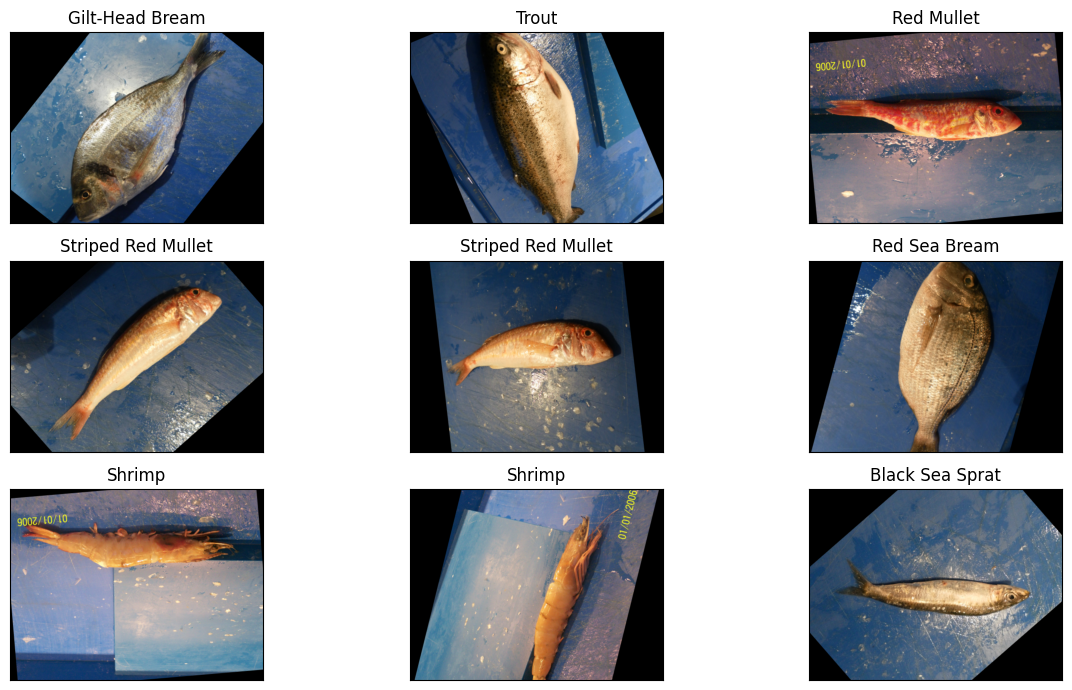

In [5]:
# Showing 9Images
import matplotlib.pyplot as plt
f,a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])

plt.tight_layout()
plt.show()

In [6]:
img_df['Labels'].value_counts(ascending=True)


Labels
Gilt-Head Bream       1000
Trout                 1000
Red Mullet            1000
Striped Red Mullet    1000
Red Sea Bream         1000
Shrimp                1000
Black Sea Sprat       1000
Sea Bass              1000
Hourse Mackerel       1000
Name: count, dtype: int64

In [7]:


train_ratio = 0.75
validation_ratio = 0.10
test_ratio = 0.15


# Dividir datos en conjuntos de entrenamiento, validación y prueba
x_train, x_test = train_test_split(img_df, test_size=1 - train_ratio)
x_val, x_test = train_test_split(x_test, test_size=test_ratio / (test_ratio + validation_ratio))

# Crear copia del conjunto de prueba
x_testt = x_test.copy()

# Parámetros de entrada para las capas convolucionales
img_size = (224, 224)
input_shape = (img_size[0], img_size[1], 3)  # 3 canales para imágenes en color (RGB)

# Preprocesamiento de imágenes con ImageDataGenerator
img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Crear generadores de flujo de datos
batch_size = 32
train_generator = img_datagen.flow_from_dataframe(
    dataframe=x_train,
    x_col='FilePaths',
    y_col='Labels',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    seed=42
)

val_generator = img_datagen.flow_from_dataframe(
    dataframe=x_val,
    x_col='FilePaths',
    y_col='Labels',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    seed=42
)

test_generator = img_datagen.flow_from_dataframe(
    dataframe=x_test,
    x_col='FilePaths',
    y_col='Labels',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    seed=42,
    shuffle=False  # No es necesario mezclar el conjunto de prueba
)

# Crear modelo CNN
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(9, activation='softmax')
])

# Compilar el modelo
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo utilizando los generadores de flujo de datos
history = cnn_model.fit(train_generator, validation_data=val_generator, epochs=5)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = cnn_model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')



Found 6750 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.



Epoch 1/5


211/211 [==============================] - 561s 3s/step - loss: 1.2176 - accuracy: 0.5613 - val_loss: 0.3838 - val_accuracy: 0.8833
Epoch 2/5
211/211 [==============================] - 468s 2s/step - loss: 0.3260 - accuracy: 0.8901 - val_loss: 0.1584 - val_accuracy: 0.9467
Epoch 3/5
211/211 [==============================] - 988s 5s/step - loss: 0.1390 - accuracy: 0.9524 - val_loss: 0.0791 - val_accuracy: 0.9722
Epoch 4/5
211/211 [==============================] - 525s 2s/step - loss: 0.0885 - accuracy: 0.9707 - val_loss: 0.0840 - val_accuracy: 0.9722
Epoch 5/5
43/43 [==============================] - 83s 2s/step - loss: 0.0763 - accuracy: 0.9748
Test accuracy: 0.9748148322105408
